In [7]:
using Logging
using Plots, DataFrames, StatsPlots, Distributions
using BenchmarkTools

include("simul_functions.jl")
include("construction_functions.jl")
include("station_functions.jl")
include("train_functions.jl")
include("pathfinding_functions.jl")
include("commuter_functions.jl")
include("classes.jl")
include("heap_functions.jl")
include("hdf5_functions.jl")

store_final_data (generic function with 1 method)

In [2]:
# io = open("log.txt", "w+")
# logger = SimpleLogger(io)
logger = ConsoleLogger(stdout, Logging.Debug)
# fileLogger = SimpleLogger(io, Logging.Debug)
# global_logger(fileLogger)
global_logger(logger)

ConsoleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(Base.Libc.WindowsRawSocket(0x00000000000003e4) open, 0 bytes waiting))), Info, Logging.default_metafmt, true, 0, Dict{Any, Int64}())

In [3]:

max_time = 10000
station_data = """Station 1,red01
Station 2,red02/pur02
Station 3,red03/pur03
Station 4,pur01
Station 5,pur04"""

travel_data = Dict(
	"pur" => """pur01,pur02,2
pur02,pur03,2
pur03,pur04,2""",
	"red" => """red01,red02,2
red02,red03,2"""
	)

# not being used at the moment
train_wait_time = """red01,1
red02,1
red03,1
pur01,1
pur04,1"""

trainPeriod = 1
trainCapacity = 150

spawn_labels = ["Station 1", "Station 2", "Station 3", "Station 4", "Station 5"]
spawn_rates = [0 2 2 2 2;
1 0 1 1 1;
3 3 0 3 3;
1 1 1 0 1;
1 1 1 1 0]

station_dict = construct_station_dict(station_data)

station_name_id_map = construct_station_name_id_map(station_dict)

# construct the edges
start_stations = construct_edges_from_edges_dict!(station_dict, travel_data)

lines = construct_lines_from_start_stations(station_dict, start_stations)

commuter_graph = construct_commuter_graph(station_dict)

floyd_warshall!(commuter_graph)

get_all_path_pairs!(commuter_graph)

paths = get_interchange_paths(station_dict, lines, commuter_graph)

trains = Dict()
events = []
for line_code in keys(lines)
	line_duration = get_line_duration(station_dict, lines, line_code)
	depot_id = lines[line_code]["FW"][1]
	result = create_period_train_placement_events(line_code, line_duration, 2, 100, depot_id)

	for (k,v) in result["trains"]
		trains[k] = v 
	end 

	append!(events, result["events"])
end

# spawn_events = create_spawn_events(spawn_labels, spawn_rates, station_name_id_map)

# append!(events, spawn_events)

metro = Metro(station_dict, trains, lines, paths);

┌ Debug: floyd_warshall done
└ @ Main C:\Users\gabes\Documents\HighPerformanceComputing\Project\HPC_Project\pathfinding_functions.jl:41


In [12]:
round(rand(Exponential(2), 1)[1]; digits=2)

3.35

In [9]:
build_min_heap!(events)

In [10]:
events

15-element Vector{Any}:
 Event(0.0, train_reach_station!, Dict{Symbol, Any}(:station => "station_4", :train => "train_pur_7", :time => 0))
 Event(0.0, train_reach_station!, Dict{Symbol, Any}(:station => "station_1", :train => "train_red_3", :time => 0))
 Event(4.0, train_reach_station!, Dict{Symbol, Any}(:station => "station_4", :train => "train_pur_8", :time => 4.0))
 Event(6.0, train_reach_station!, Dict{Symbol, Any}(:station => "station_4", :train => "train_pur_2", :time => 6.0))
 Event(2.0, train_reach_station!, Dict{Symbol, Any}(:station => "station_4", :train => "train_pur_5", :time => 2.0))
 Event(4.0, train_reach_station!, Dict{Symbol, Any}(:station => "station_1", :train => "train_red_6", :time => 4.0))
 Event(8.0, train_reach_station!, Dict{Symbol, Any}(:station => "station_1", :train => "train_red_5", :time => 8.0))
 Event(14.0, train_reach_station!, Dict{Symbol, Any}(:station => "station_4", :train => "train_pur_3", :time => 14.0))
 Event(16.0, train_reach_station!, Dict{Sy

In [11]:
for i in 1:15
    println(heappop!(events))
end

Event(0.0, train_reach_station!, Dict{Symbol, Any}(:station => "station_4", :train => "train_pur_7", :time => 0))
Event(0.0, train_reach_station!, Dict{Symbol, Any}(:station => "station_1", :train => "train_red_3", :time => 0))
Event(2.0, train_reach_station!, Dict{Symbol, Any}(:station => "station_4", :train => "train_pur_5", :time => 2.0))
Event(2.0, train_reach_station!, Dict{Symbol, Any}(:station => "station_1", :train => "train_red_4", :time => 2.0))
Event(4.0, train_reach_station!, Dict{Symbol, Any}(:station => "station_4", :train => "train_pur_8", :time => 4.0))
Event(4.0, train_reach_station!, Dict{Symbol, Any}(:station => "station_1", :train => "train_red_6", :time => 4.0))
Event(6.0, train_reach_station!, Dict{Symbol, Any}(:station => "station_1", :train => "train_red_1", :time => 6.0))
Event(6.0, train_reach_station!, Dict{Symbol, Any}(:station => "station_4", :train => "train_pur_2", :time => 6.0))
Event(8.0, train_reach_station!, Dict{Symbol, Any}(:station => "station_4", 

In [15]:
display(commuter_graph.commuter_paths["station_1.red"]["station_5.pur"])

2-element Vector{Any}:
 ["station_1.red", "station_2.red", "station_2.pur", "station_3.pur", "station_5.pur"]
 ["station_1.red", "station_2.red", "station_3.red", "station_3.pur", "station_5.pur"]

In [28]:
get_line_duration(station_dict, lines, "red")

12.0

In [32]:
result = create_period_train_placement_events("red", 12, 2, 100, "station_1")

Dict{Any, Any} with 2 entries:
  "events" => Any[Event(0, train_reach_station!, Dict{Symbol, Any}(:station=>"s…
  "trains" => Dict{Any, Any}("train_red_6//1"=>Train("train_red_6//1", "red", "…

In [48]:
result["events"][2]

Event(2, train_reach_station!, Dict{Symbol, Any}(:station => "station_1", :train => "train_red_3//1", :time => 2.0))

In [27]:
lines["red"]["FW"][1]

"station_1"

In [17]:
for i in keys(station_dict)
    print(i)
end

station_5station_2station_1station_3station_4

In [44]:
station_dict["station_5"].codes

1-element Vector{Any}:
 "pur"

In [63]:
lines

Dict{Any, Any} with 2 entries:
  "pur" => Dict{Any, Any}("FW"=>["station_4", "station_2", "station_3", "statio…
  "red" => Dict{Any, Any}("FW"=>["station_1", "station_2", "station_3"], "BW"=>…

In [51]:
for (x, y) in [(1,23), (23,1)]
    println(x)
    println(y)
end

1
23
23
1


In [64]:
findfirst(==("station_5"), lines["pur"]["FW"])

4

In [74]:
paths = get_interchange_paths(station_dict, lines, commuter_graph)

Dict{Any, Any} with 5 entries:
  "station_4" => Dict{Any, Any}("station_2"=>Dict{Any, Any}("pur_FW"=>Any["stat…
  "station_2" => Dict{Any, Any}("station_4"=>Dict{Any, Any}("pur_BW"=>Any["stat…
  "station_1" => Dict{Any, Any}("station_4"=>Dict{Any, Any}("red_FW"=>Any["stat…
  "station_3" => Dict{Any, Any}("station_2"=>Dict{Any, Any}("red_BW"=>Any["stat…
  "station_5" => Dict{Any, Any}("station_2"=>Dict{Any, Any}("pur_BW"=>Any["stat…

In [78]:
paths["station_2"]

Dict{Any, Any} with 4 entries:
  "station_4" => Dict{Any, Any}("pur_BW"=>Any["station_4"])
  "station_1" => Dict{Any, Any}("red_BW"=>Any["station_1"])
  "station_3" => Dict{Any, Any}("red_FW"=>Any["station_3"], "pur_FW"=>Any["stat…
  "station_5" => Dict{Any, Any}("pur_FW"=>Any["station_5"])

In [71]:
size(lines["red"]["FW"])[1]

3

In [45]:
trunc(Int, 4/3)

1

In [12]:
rand(Exponential(2), 1)[1]

0.8827619021614435

In [24]:
x = [1, 2, 3]

3-element Vector{Int64}:
 1
 2
 3

In [25]:
for i in 3: -1 : 1
    if i == 2
        println(splice!(x,i))
    end
end

2


In [2]:
using HDF5

In [3]:
data = h5open("data/runsData.h5")

🗂️ HDF5.File: (read-only) data/runsData.h5
└─ 📂 dataset_d_100_run_2023-04-06T20:57:52.892
   ├─ 📂 percentage_wait_time
   │  ├─ 📂 station_1
   │  │  ├─ 🔢 station_2
   │  │  ├─ 🔢 station_3
   │  │  ├─ 🔢 station_4
   │  │  └─ 🔢 station_5
   │  ├─ 📂 station_2
   │  │  ├─ 🔢 station_1
   │  │  ├─ 🔢 station_3
   │  │  ├─ 🔢 station_4
   │  │  └─ 🔢 station_5
   │  ├─ 📂 station_3
   │  │  ├─ 🔢 station_1
   │  │  ├─ 🔢 station_2
   │  │  ├─ 🔢 station_4
   │  │  └─ 🔢 station_5
   │  ├─ 📂 station_4
   │  │  ├─ 🔢 station_1
   │  │  ├─ 🔢 station_2
   │  │  ├─ 🔢 station_3
   │  │  └─ 🔢 station_5
   │  └─ 📂 station_5
   │     ├─ 🔢 station_1
   │     ├─ 🔢 station_2
   │     ├─ 🔢 station_3
   │     └─ 🔢 station_4
   ├─ 📂 station_commuter_count
   │  ├─ 📂 station_1
   │  │  ├─ 🔢 count
   │  │  ├─ 🔢 event
   │  │  └─ 🔢 time
   │  ├─ 📂 station_2
   │  │  ├─ 🔢 count
   │  │  ├─ 🔢 event
   │  │  └─ 🔢 time
   │  ├─ 📂 station_3
   │  │  ├─ 🔢 count
   │  │  ├─ 🔢 event
   │  │  └─ 🔢 time
   │  ├─ 📂 station_4
   │

In [28]:
f = data["dataset_d_100_run_2023-04-06T20:57:52.892/wait_times/station_2"]

🔢 HDF5.Dataset: /dataset_d_100_run_2023-04-06T20:57:52.892/wait_times/station_2 (file: data/runsData.h5 xfer_mode: 0)

In [29]:
read(f)

1640-element Vector{Float64}:
 3.9052252711392663
 3.8005350488928493
 3.7097047820470253
 3.5532935727606842
 3.4020533586307655
 2.90004882011739
 2.6012672038052957
 2.5569343424910826
 2.5483979482571923
 1.5806013831097911
 1.4089182876476012
 1.1944831986135425
 1.1623315229180586
 ⋮
 1.0
 0.754263511224309
 0.23297299652611514
 0.19572753949253752
 0.044112404526984506
 1.949006254734286
 1.3682381911176549
 1.2902487406537375
 1.248633815165661
 1.0
 0.754263511224309
 0.19572753949253752

In [30]:
using Plots

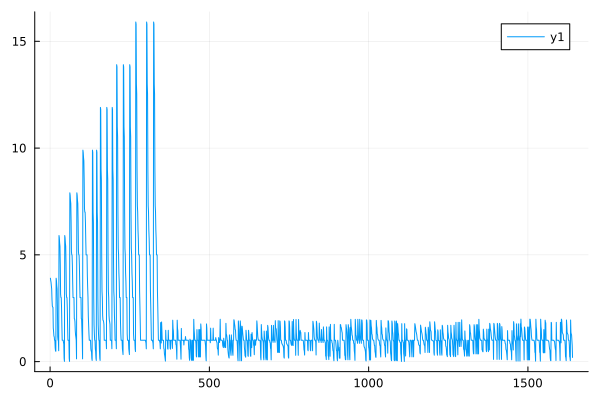

In [31]:
plot(read(f))